In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [2]:
class ResNet_normal(nn.Module):
    def __init__(self,block,layers,num_classes=100):
        super(ResNet_normal,self).__init__()
        self.in_channels=64
        self.conv1=nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self.make_layer(block,64,layers[0])
        self.layer2=self.make_layer(block,128,layers[1],2)
        self.layer3=self.make_layer(block,256,layers[2],2)
        self.layer4=self.make_layer(block,512,layers[3],2)
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
                )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.bn(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.layer1(out)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.avg_pool(out)
        out=torch.flatten(out,1)
        out=self.fc(out)
        return out

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
from basic_tools import *

In [4]:
#一些参数的设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.01
momentum=0.9
weight_decay=0.0001
batch_size=128
epochs=100
data_path='./data'
model_name='BasicResNet'+'epoch='+str(epochs)
print(device)
model=ResNet_normal(BasicBlock,[2,2,2,2]).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [5]:
#数据集的加载
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

Files already downloaded and verified
Files already downloaded and verified


epoch:0,train_loss:3.8177,train_acc:11.7120,train_top5_acc:32.9160,test_loss:3.3838,test_acc:18.7900,test_top5_acc:46.8700
epoch:1,train_loss:3.2168,train_acc:20.8140,train_top5_acc:49.9300,test_loss:2.9645,test_acc:26.1700,test_top5_acc:57.4300
epoch:2,train_loss:2.8683,train_acc:27.3580,train_top5_acc:58.7620,test_loss:2.7612,test_acc:29.8100,test_top5_acc:61.1900
epoch:3,train_loss:2.6510,train_acc:31.3940,train_top5_acc:63.9160,test_loss:2.7041,test_acc:32.0100,test_top5_acc:63.0700
epoch:4,train_loss:2.4790,train_acc:35.0480,train_top5_acc:67.6620,test_loss:2.4821,test_acc:35.4600,test_top5_acc:67.8000
epoch:5,train_loss:2.3407,train_acc:37.8740,train_top5_acc:70.7320,test_loss:2.3245,test_acc:39.2300,test_top5_acc:70.9200
epoch:6,train_loss:2.2103,train_acc:40.7620,train_top5_acc:73.3200,test_loss:2.4229,test_acc:37.7900,test_top5_acc:69.1300
epoch:7,train_loss:2.1067,train_acc:43.4820,train_top5_acc:75.4300,test_loss:2.2037,test_acc:41.7600,test_top5_acc:73.4900
epoch:8,train_lo

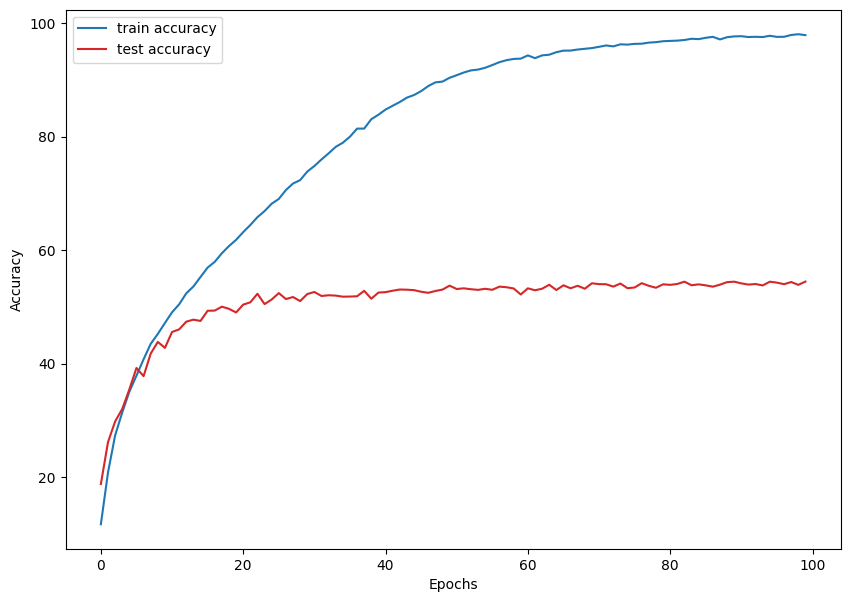

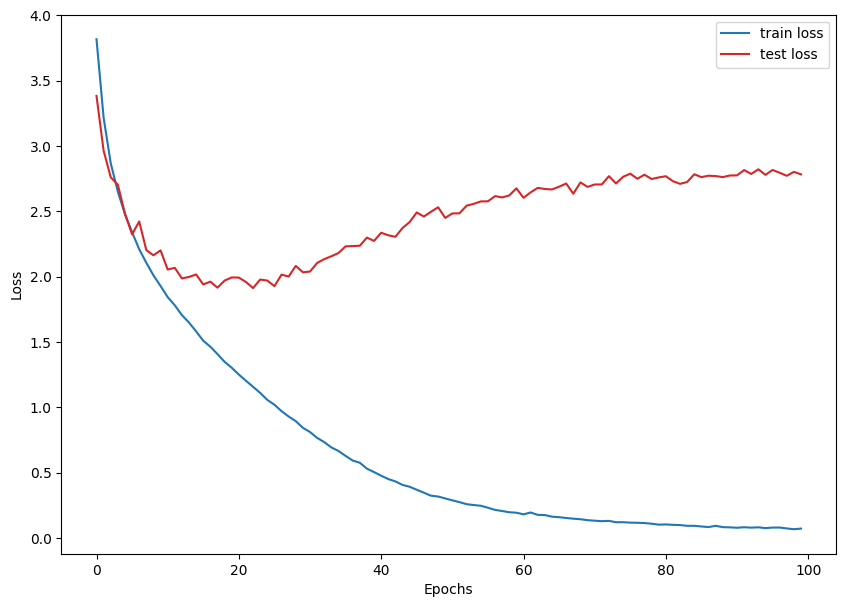

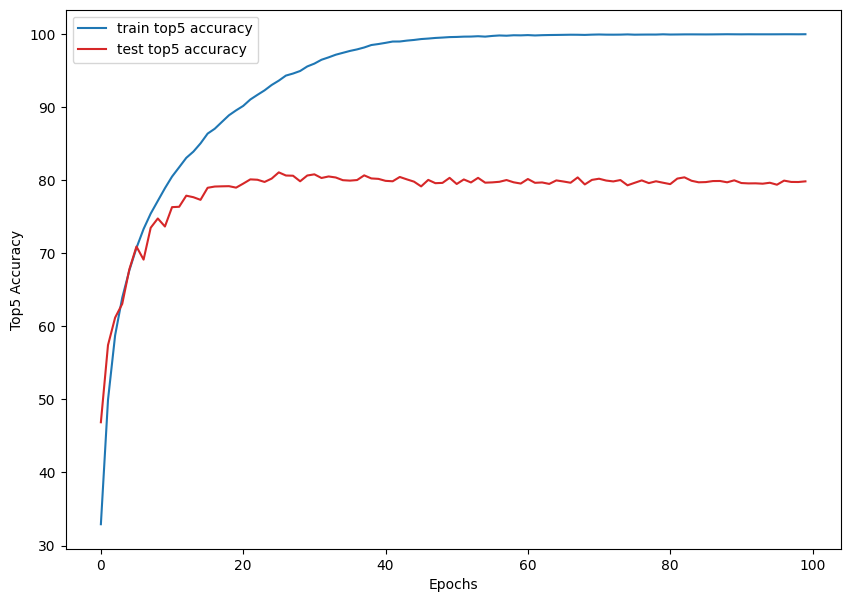

In [6]:
#训练之
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(epoch,train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    #torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)
save_log(model_name,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca)
save_model_info(model_name,model,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,learning_rate,epochs,momentum,weight_decay)

In [7]:
#固定模型
import os
modelpath='./models/'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
torch.save(model.state_dict(),modelpath+model_name+'.pth')